In [1]:
import warnings
import pandas as pd
from PIL import Image
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torchvision
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [2]:
warnings.filterwarnings("ignore")

### Params


In [3]:
DEVICE = "cpu"
WORK_DIR = "../.."
MODEL_PATH = "models/detection/fasterrcnn9e.pth"
TRAIN_PATH = "data/open_image_dataset/train_remote.parquet"

### Load model and classes


In [4]:
# load model
model = fasterrcnn_resnet50_fpn(pretrained=False)
in_features = model.roi_heads.box_predictor.cls_score.in_features

df = pd.read_parquet(join(WORK_DIR, TRAIN_PATH))
num_classes = df["class"].max() + 1
model.roi_heads.box_predictor = (
    torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
)
model.load_state_dict(torch.load(join(WORK_DIR, MODEL_PATH), map_location=DEVICE))
model.to(DEVICE)
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [5]:
# load classes
id2name = dict(zip(df["class"], df["class_name"]))

### Predict


In [6]:
def resize(image, min_size=800, max_size=800):
    orig_width, orig_height = image.size
    min_orig_size = float(min((orig_width, orig_height)))
    max_orig_size = float(max((orig_width, orig_height)))

    scale = min_size / min_orig_size
    if max_orig_size * scale > max_size:
        scale = max_size / max_orig_size

    new_width = int(round(orig_width * scale))
    new_height = int(round(orig_height * scale))

    return F.resize(image, (new_height, new_width))


def predict(image_path, n_print=3, print_precision=3):
    image = resize(Image.open(image_path)).convert("RGB")
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )
    image_tensor = transform(image).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        prediction = model(image_tensor)

    pred_boxes = prediction[0]["boxes"]
    pred_scores = prediction[0]["scores"]
    pred_labels = prediction[0]["labels"]

    for label, score in list(
        zip([id2name[x] for x in pred_labels.numpy()], pred_scores.to("cpu").tolist())
    )[:n_print]:
        print(f"{label}: {round(score, print_precision)}")

    idx = torch.argmax(pred_scores)
    pred_boxes = pred_boxes[idx]
    pred_scores = pred_scores[idx]
    pred_labels = pred_labels[idx]

    return image, pred_boxes, pred_labels, pred_scores


def plot_prediction(
    image,
    boxes,
    labels,
    scores,
    width=12,
    height=9,
    fontsize=10,
    linewidth=2,
    label_x_shift=5,
    label_y_shift=-15,
    alpha=0.5,
):
    fig, ax = plt.subplots(1, figsize=(width, height))
    ax.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=linewidth,
            edgecolor="r",
            facecolor="none",
        )
        ax.add_patch(rect)
        ax.text(
            x1 + label_x_shift,
            y1 + label_y_shift,
            f"Name: {id2name[label.item()].title()} \nScore: {score:.2f}",
            bbox=dict(facecolor="white", alpha=alpha),
            fontsize=fontsize,
        )

    plt.axis("off")
    plt.show()

##### Visual evaluation


Dessert: 0.352
Dessert: 0.283
Dessert: 0.177


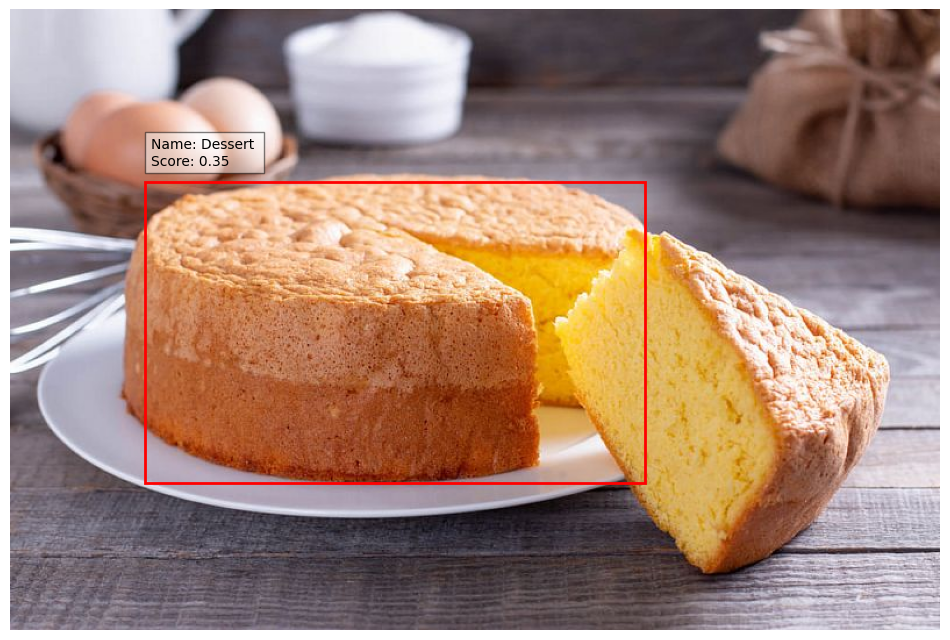

CPU times: user 4.49 s, sys: 3.51 s, total: 8 s
Wall time: 1.22 s


In [7]:
%%time
img_path = "data/evaluate/detection/1.jpg"
img, boxes, labels, scores = predict(join(WORK_DIR, img_path))
plot_prediction(img, [boxes], [labels], [scores])

Cucumber: 0.086
Cheese: 0.068
Cucumber: 0.056


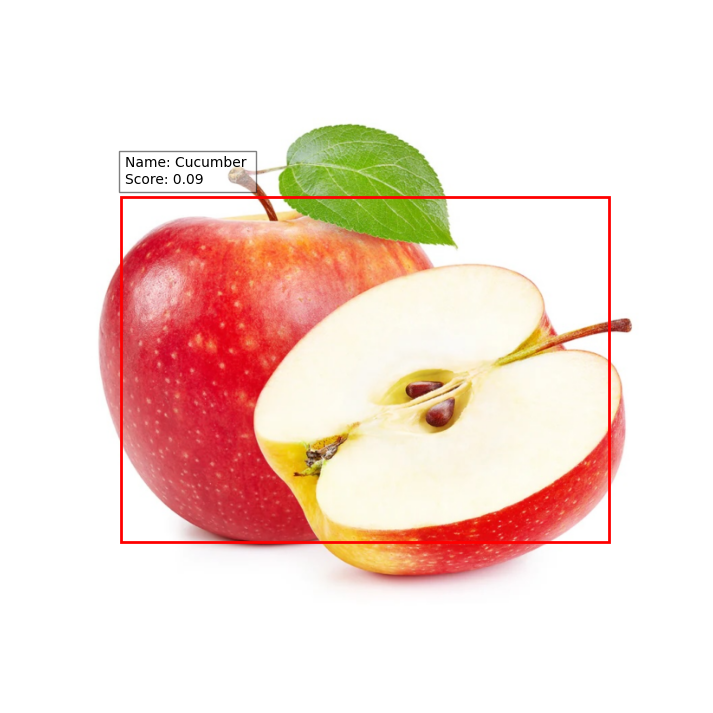

CPU times: user 3.74 s, sys: 1.78 s, total: 5.51 s
Wall time: 721 ms


In [8]:
%%time
img_path = "data/evaluate/detection/2.jpg"
img, boxes, labels, scores = predict(join(WORK_DIR, img_path))
plot_prediction(img, [boxes], [labels], [scores])

Cheese: 0.203
Dessert: 0.182
Muffin: 0.167


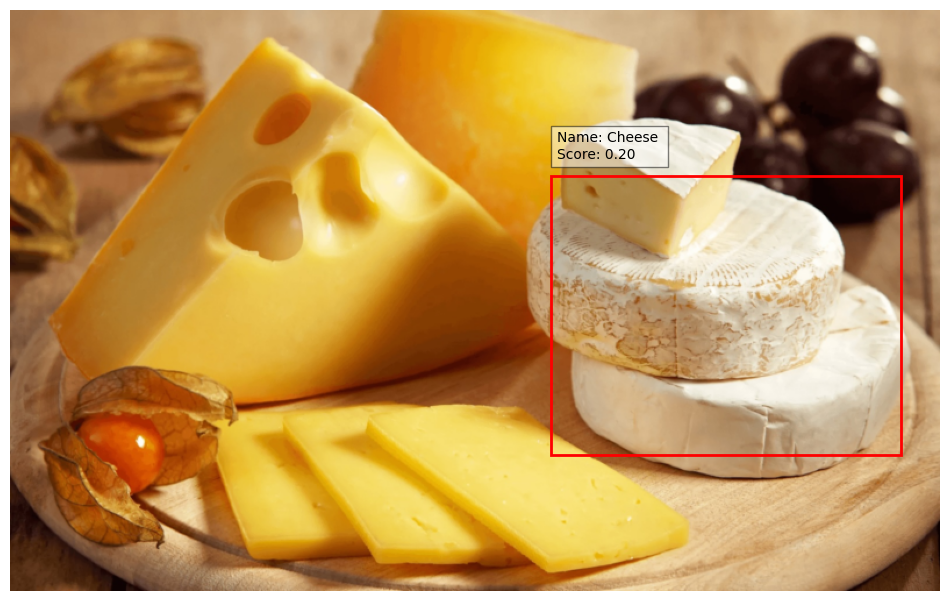

CPU times: user 5.53 s, sys: 2.96 s, total: 8.49 s
Wall time: 1.13 s


In [9]:
%%time
img_path = "data/evaluate/detection/3.jpg"
img, boxes, labels, scores = predict(join(WORK_DIR, img_path))
plot_prediction(img, [boxes], [labels], [scores])

Dessert: 0.182
Pasta: 0.102
Waffle: 0.071


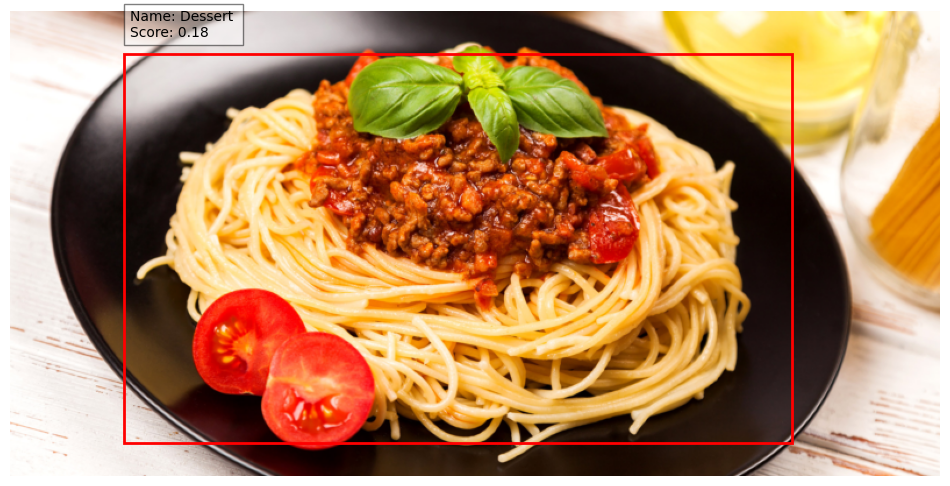

CPU times: user 4.74 s, sys: 2.24 s, total: 6.99 s
Wall time: 911 ms


In [10]:
%%time
img_path = "data/evaluate/detection/4.jpg"
img, boxes, labels, scores = predict(join(WORK_DIR, img_path))
plot_prediction(img, [boxes], [labels], [scores])

Dessert: 0.232
Cheese: 0.109
Muffin: 0.103


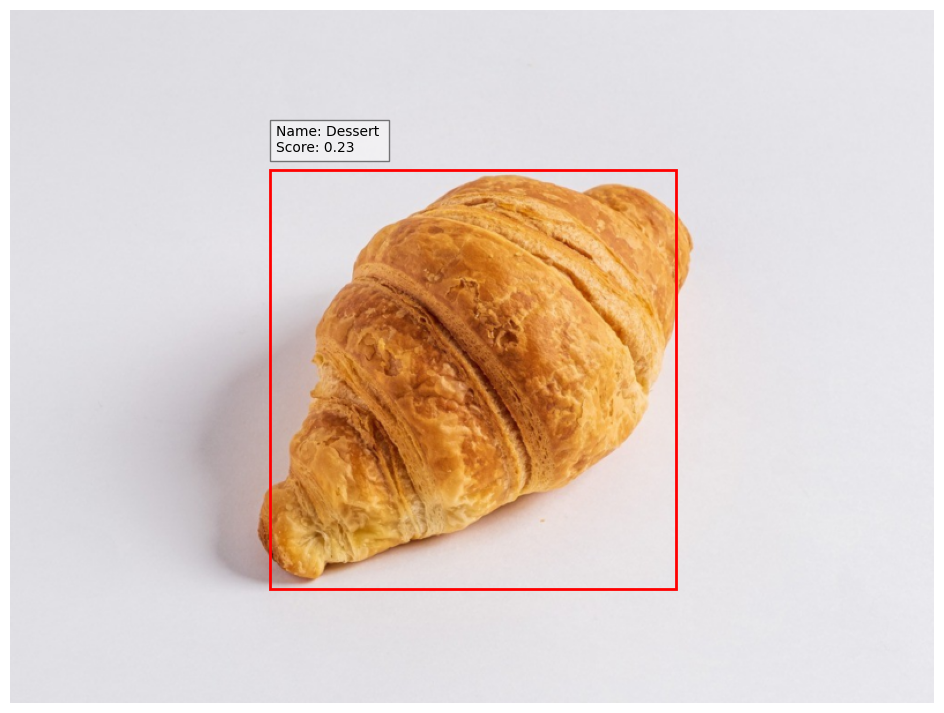

CPU times: user 4.57 s, sys: 2.13 s, total: 6.7 s
Wall time: 847 ms


In [11]:
%%time
img_path = "data/evaluate/detection/5.jpg"
img, boxes, labels, scores = predict(join(WORK_DIR, img_path))
plot_prediction(img, [boxes], [labels], [scores])

Cucumber: 0.1
Cucumber: 0.065


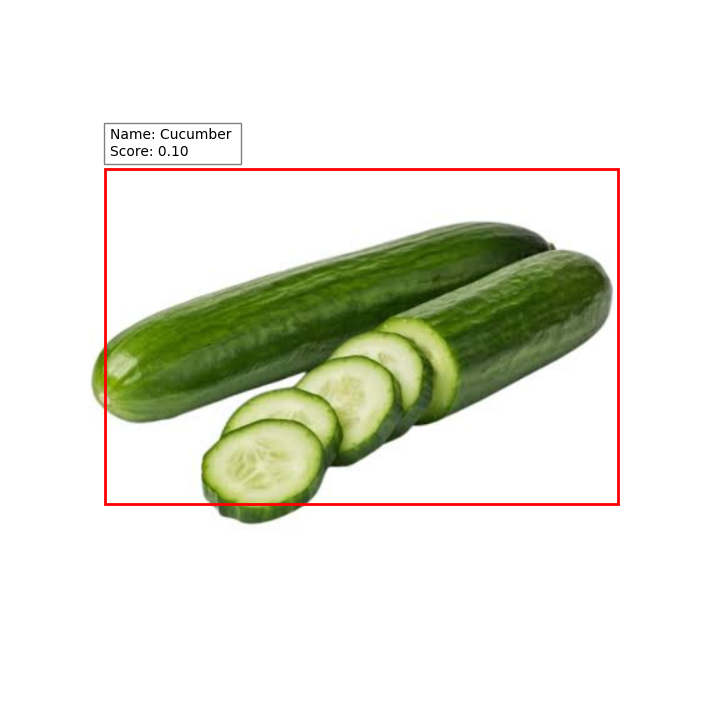

CPU times: user 3.86 s, sys: 1.55 s, total: 5.42 s
Wall time: 648 ms


In [12]:
%%time
img_path = "data/evaluate/detection/6.jpg"
img, boxes, labels, scores = predict(join(WORK_DIR, img_path))
plot_prediction(img, [boxes], [labels], [scores])

Muffin: 0.274
Dessert: 0.161
Dessert: 0.136


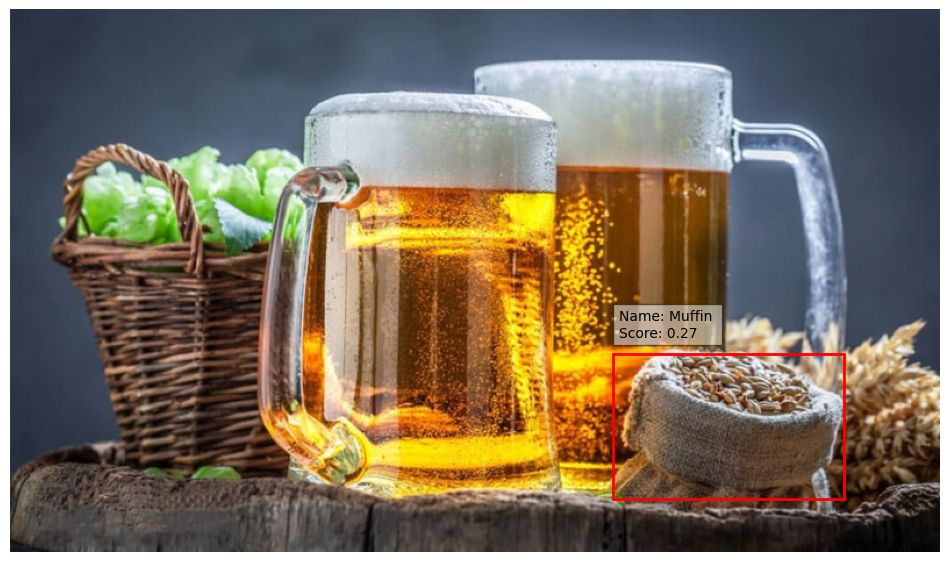

CPU times: user 5.43 s, sys: 2.6 s, total: 8.02 s
Wall time: 1.04 s


In [13]:
%%time
img_path = "data/evaluate/detection/7.jpg"
img, boxes, labels, scores = predict(join(WORK_DIR, img_path))
plot_prediction(img, [boxes], [labels], [scores])